# Introduction

We have gathered daily price data for the Iranian Gold Coin along with its corresponding option data. This data has been partially cleaned, with some features added and others dropped.

The objective of this notebook is to:

1. Prepare the price data and apply various machine learning, deep learning, and statistical models to forecast the price for future intervals.

2. Prepare the option data, utilize the forecasting from the first part, and employ the "Stochastic Calculus Models" module to identify profitable options.

### Notes
1. This notebook is a work in progress and will require further development in the future.

2. Real option pricing and analysis require additional data from other correlated assets and derivatives to ensure reliability.

3. Real option pricing and analysis necessitate more rigorous methods, potentially including tuned models and customized stochastic differential equations beyond standard approaches.

4. Interpretation of models and results is a critical aspect that remains incomplete in this work.

5. More historical and trading data is needed to enhance the robustness and reliability of our results.

# Data Preparation

In [77]:

import math
import talib
import random 
import statistics
import numpy as np
import pandas as pd
from numpy.random import seed
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_regression
from StochasticCalculusModeling import *

import warnings
warnings.filterwarnings('ignore')

In [19]:
GoldCoinPrice = pd.read_csv(r"C:\Users\Aleph.LAPTOP-5AKK0J1L\Desktop\Option Pricing\GoldCoinPrice.csv")
GoldCoinPrice.index = GoldCoinPrice['Date']
GoldCoinPrice = GoldCoinPrice.drop(['Change', 'ChangePercent'], axis=1)
GoldCoinPrice.head()

,Date,Open,Low,High,Close
Date,,,,,
1397/01/14,1397/01/14,17310000,17290000,17460000,17360000
1397/01/15,1397/01/15,17390000,17390000,17490000,17490000
1397/01/16,1397/01/16,17390000,17390000,17390000,17390000
1397/01/17,1397/01/17,17560000,17550000,17910000,17830000
1397/01/18,1397/01/18,18050000,18050000,19560000,19300000


In [10]:
GoldCoinOptions = pd.read_csv(r"C:\Users\Aleph.LAPTOP-5AKK0J1L\Desktop\Option Pricing\GoldCoinOptions.csv")
GoldCoinOptions.head()

,حجم,ارزش(ریال),بالاترین(ریال),پایین ترین(ریال),آخرین(ریال),اولین(ریال),موقعیتهای باز,درصد تغییر,تعداد مشتریان فعال,تعداد کارگزاران فعال,...,قیمت تسویه (ریال),درصد تغییر قیمت تسویه,تاریخ,تاریخ اعمال,#!ارزش معاملات مشتریان حقیقی(خرید)(ریال),#!ارزش معاملات مشتریان حقیقی(فروش)(ریال),ContractType,StrikePrice,Profitability,ContractDurationDays
0,0,0,0,0,0,0,39,0,21,7,...,4900000,0.00,1398/01/15,1398/02/16,0,0,C,46000000,1,32
1,11,54040000,5500000,4700000,4890000,5500000,40,0,22,10,...,4912727,18.12,1398/01/15,1398/02/16,54040000,54040000,C,44000000,1,32
2,14,34763400,2899400,2300000,2300400,2899400,352,-6,51,11,...,2483100,8.62,1398/01/15,1398/02/16,34763400,34763400,C,48000000,1,32
3,0,0,0,0,0,0,17,0,13,4,...,1145568,0.00,1398/01/15,1398/02/16,0,0,P,44000000,0,32
4,0,0,0,0,0,0,5,0,5,3,...,1573415,8.38,1398/01/15,1398/02/16,0,0,P,46000000,0,32


## Add Some Features
This section includes 8 funtions for Data Preparation:

1. Add_Lag: Add arbitrary numbers of lags of data columns.

2. Indicator: Add all possible technical analysis features to the data using "Talib" library.

3. add_diff: Add price differences of consecutive days.

4. Roll_Stats: Add simple statistics of columns like mean, standard deviation, maximum ad minimum.

5. Prepare_Data: Combine above functions and implement them on the data.

6. Combine: Consider the Label and according to it, then Prepare Data for each columns and at th end, concat or merge them together.

7. mutual_information: Due to the large number of created columns, it's better to select most related and important of them. Therefore, we calculate their mutual information score with the target column and by setting an arbitrary value like mic=3, we drop all columns which their MIC scores with the target is smaller than 3.

8. Final_Data_Preparation: The last function that all above functions will run in it. This function prepare the dataset and drop uncorrelated features and return the final clean data.

### Note
In the first version of this notebook, we assume the GoldCoinPrice data as a univariate time series with 'Close' feature.

In [73]:
def Add_Lag(data,col,lag_list):

    position = data.columns.tolist().index(col)
    
    for lag in lag_list:
    
        col_val = data[col].shift(lag)

        col_name = col+'_lag:'+'{length}'.format(length=lag)

        data.insert(loc=position, column=col_name, value=col_val)
        

    return data

def add_diff(data,col): #A simple type of features which calculate just the difference between sequential values in each columns

    position = data.columns.tolist().index(col)

    SimpleDiff = [0,0]
    LogDiff = [0,0]
    simpleReturn = [0,0]
    LogReturn = [0,0]

    for i in range(1,data.shape[0]-1):

        NaturalDifference = data[col][i] -  data[col][i-1]
        NaturalReturn = NaturalDifference / data[col][i-1]

        LogDiference = np.log(data[col][i]) - np.log(data[col][i-1])
        LogReturn_ = LogDiference / np.log(data[col][i-1])


        SimpleDiff.append(NaturalDifference)
        LogDiff.append(LogDiference)
        simpleReturn.append(NaturalReturn)
        LogReturn.append(LogReturn_)

    
    data.insert(loc=position, column=col+'_SimpleDifference', value=SimpleDiff)
    data.insert(loc=position, column=col+'_LogDifference', value=LogDiff)
    data.insert(loc=position, column=col+'_simpleReturn', value=simpleReturn)
    data.insert(loc=position, column=col+'_ LogReturn', value=LogReturn)

    return data

def Roll_Stats(data,col,Roll_Window): #Calculating simple statistics of the data
    
    lag = 1

    position = data.columns.tolist().index(col)
    
    for window in Roll_Window:
        
        Window = window
        col_val = data[col].shift(lag)
        window = col_val.rolling(window=window)
        means = window.mean()
        std = window.var()
        Max  = window.max()
        Min = window.min()
    
        col_name_mean = col+'_mean'+'_lag:'+'{length}'.format(length=lag)+\
        '_win:'+'{length}'.format(length=Window)
        col_name_std = col+'_std'+'_lag:'+'{length}'.format(length=lag)+\
        '_win:'+'{length}'.format(length=Window)
        col_name_max = col+'_max'+'_lag:'+'{length}'.format(length=lag)+\
        '_win:'+'{length}'.format(length=Window)
        col_name_min = col+'_min'+'_lag:'+'{length}'.format(length=lag)+\
        '_win:'+'{length}'.format(length=Window)


        data.insert(loc=position, column=col_name_mean, value=means)
        data.insert(loc=position, column=col_name_std, value=std)
        data.insert(loc=position, column=col_name_max, value=Max)
        data.insert(loc=position, column=col_name_min, value=Min)

    return data

def Add_Indicators(Data, data, col):
    target = data['Close']
    data = data.drop(['Close'],axis=1)
    # RSI period (default is 14)
    rsi = talib.RSI(data[col].values, timeperiod=14)

    macd, macd_signal, _ = talib.MACD(data[col].values)
    slowk, slowd = talib.STOCH(high=Data['High'].shift(1).values, low=Data['Low'].shift(1).values, close=data[col].values)
    upper_band, middle_band, lower_band = talib.BBANDS(data[col].values)
    sma = talib.SMA(data[col].values)

    # Add indicators to the DataFrame
    data['MACD'] = macd
    data['MACD_signal'] = macd_signal
    data['RSI'] = rsi
    data['Stochastic_SlowK'] = slowk
    data['Stochastic_SlowD'] = slowd
    data['BBands_upper'] = upper_band
    data['BBands_middle'] = middle_band
    data['BBands_lower'] = lower_band
    data['SMA'] = sma
    data['Close'] = target

    return data



def FeatureExtractor(data,lag_list,window_list):

    data = Add_Lag(data, 'Close',lag_list)
    data = add_diff(data, 'Close')
    data = Roll_Stats(data,'Close', window_list)
    data = Add_Indicators(GoldCoinPrice,data,'Close_lag:1')
    data = data.dropna()
    return data

In [75]:
data = pd.DataFrame(GoldCoinPrice['Close'])
Added_data = FeatureExtractor(data,[1,5,10,20],[50,10,20])
Added_data

,Close_lag:20,Close_lag:10,Close_lag:5,Close_lag:1,Close_ LogReturn,Close_simpleReturn,Close_LogDifference,Close_SimpleDifference,Close_min_lag:1_win:20,Close_max_lag:1_win:20,...,MACD,MACD_signal,RSI,Stochastic_SlowK,Stochastic_SlowD,BBands_upper,BBands_middle,BBands_lower,SMA,Close
Date,,,,,,,,,,,,,,,,,,,,,
1397/03/03,20475000.0,19050000.0,19560000.0,20360000.0,0.000853,0.014449,0.014346,290000,18980000.0,21060000.0,...,2.939846e+05,3.025734e+05,59.440309,86.776860,83.220879,2.054160e+07,20016000.0,1.949040e+07,1.946883e+07,20220000
1397/03/04,20370000.0,19380000.0,19960000.0,20220000.0,-0.000410,-0.006876,-0.006900,-140000,18980000.0,21060000.0,...,2.993009e+05,3.019189e+05,57.636504,87.071787,85.680426,2.041912e+07,20148000.0,1.987688e+07,1.956050e+07,20310000
1397/03/05,18980000.0,19750000.0,20130000.0,20310000.0,0.000264,0.004451,0.004441,90000,18980000.0,21060000.0,...,3.072348e+05,3.029821e+05,58.508209,90.493740,88.114129,2.043393e+07,20218000.0,2.000207e+07,1.964850e+07,20450000
1397/03/06,20020000.0,19760000.0,20070000.0,20450000.0,0.000408,0.006893,0.006870,140000,19040000.0,21060000.0,...,3.211177e+05,3.066092e+05,59.890796,88.161020,88.575516,2.054104e+07,20282000.0,2.002296e+07,1.974117e+07,20775000
1397/03/07,20190000.0,19360000.0,20360000.0,20775000.0,0.000937,0.015892,0.015767,325000,19040000.0,21060000.0,...,3.542610e+05,3.161395e+05,62.975144,92.053043,90.235934,2.080518e+07,20423000.0,2.004082e+07,1.983367e+07,21450000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1403/01/16,344580000.0,380820000.0,387780000.0,438880000.0,0.001963,0.039754,0.038984,16780000,344580000.0,438880000.0,...,1.883806e+07,1.490013e+07,91.127945,70.462110,44.725775,4.480069e+08,404914000.0,3.618211e+08,3.660283e+08,458080000
1403/01/18,368070000.0,388060000.0,387830000.0,458080000.0,0.002152,0.043748,0.042818,19200000,362880000.0,458080000.0,...,2.245962e+07,1.641203e+07,92.893358,98.056253,69.206074,4.745861e+08,418974000.0,3.633619e+08,3.702653e+08,448060000
1403/01/19,370850000.0,387930000.0,387980000.0,448060000.0,-0.001109,-0.021874,-0.022117,-10020000,362880000.0,458080000.0,...,2.424176e+07,1.797798e+07,83.549676,91.765930,86.761431,4.801435e+08,431020000.0,3.818965e+08,3.742503e+08,419970000


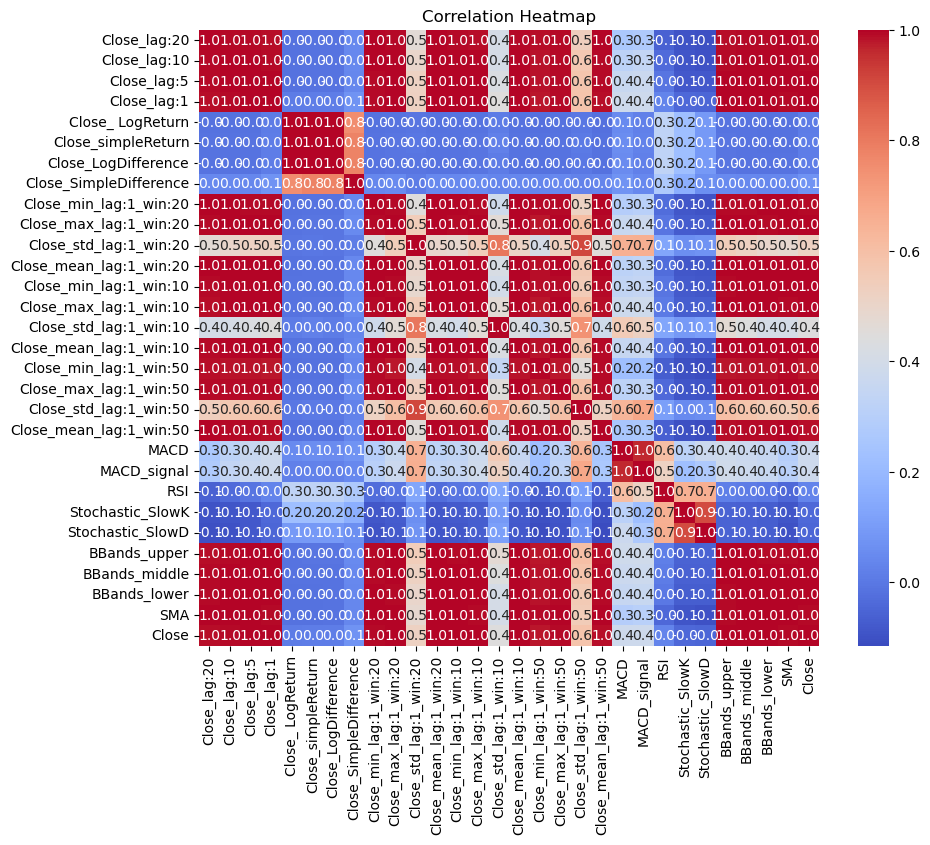

In [79]:
corr_matrix = Added_data.corr()
# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".1f")
plt.title('Correlation Heatmap')
plt.show()

In [97]:
# Calculate mutual information
mi_values = []
for column in Added_data.columns[:-1]:
    mi = mutual_info_regression(Added_data[[column]], Added_data['Close'])
    mi_values.append(mi[0])

# Calculate correlation with 'Close'
corr_values = Added_data.corr()['Close'].values

# Create the mutual information table
mi_df = pd.DataFrame({'Feature': Added_data.columns[:-1], 'Mutual_Information': mi_values, 'Correlation_with_Close': corr_values[:-1]})
mi_df = mi_df.sort_values(by='Mutual_Information', ascending=False).reset_index(drop=True)

mi_df

,Feature,Mutual_Information,Correlation_with_Close
0,Close_lag:1,3.286367,0.999222
1,Close_max_lag:1_win:10,2.933721,0.997487
2,BBands_middle,2.932369,0.998518
3,BBands_upper,2.872608,0.997877
4,Close_min_lag:1_win:10,2.870771,0.996157
5,Close_mean_lag:1_win:10,2.847098,0.997617
6,Close_max_lag:1_win:20,2.846928,0.996473
7,BBands_lower,2.823653,0.996896
8,Close_min_lag:1_win:20,2.819261,0.992881
9,Close_mean_lag:1_win:20,2.736251,0.996108


We can surely continue work on the data. 

In [103]:
train_x, train_y = Added_data.values[:1100,:-1], Added_data.values[:1100,-1]
val_x, val_y = Added_data.values[1100:1500,:-1], Added_data.values[1100:1500,-1]
test_x, test_y = Added_data.values[1500:,:-1], Added_data.values[1500:,-1]

# Forecasting Gold Coin Price

## Machine Learning Models

### 1. Linear Models